# Introduction

<div class="alert alert-warning">
<font color=black>

**What?** K-fold cross validation, grid/random search from scratch

</font>
</div>

# Import modules

In [1]:
import numpy as np
import pandas as pd

## K-Fold Cross Validation

One of the most common technique for model evaluation and model selection in machine learning practice is K-fold cross validation. The main idea behind cross-validation is that each observation in our dataset has the opportunity of being tested. K-fold cross-validation is a special case of cross-validation where we iterate over a dataset set k times. In each round, we split the dataset into $k$ parts: one part is used for validation, and the remaining $k-1$ parts are merged into a training subset for model evaluation. The figure below illustrates the process of 5-fold cross-validation:

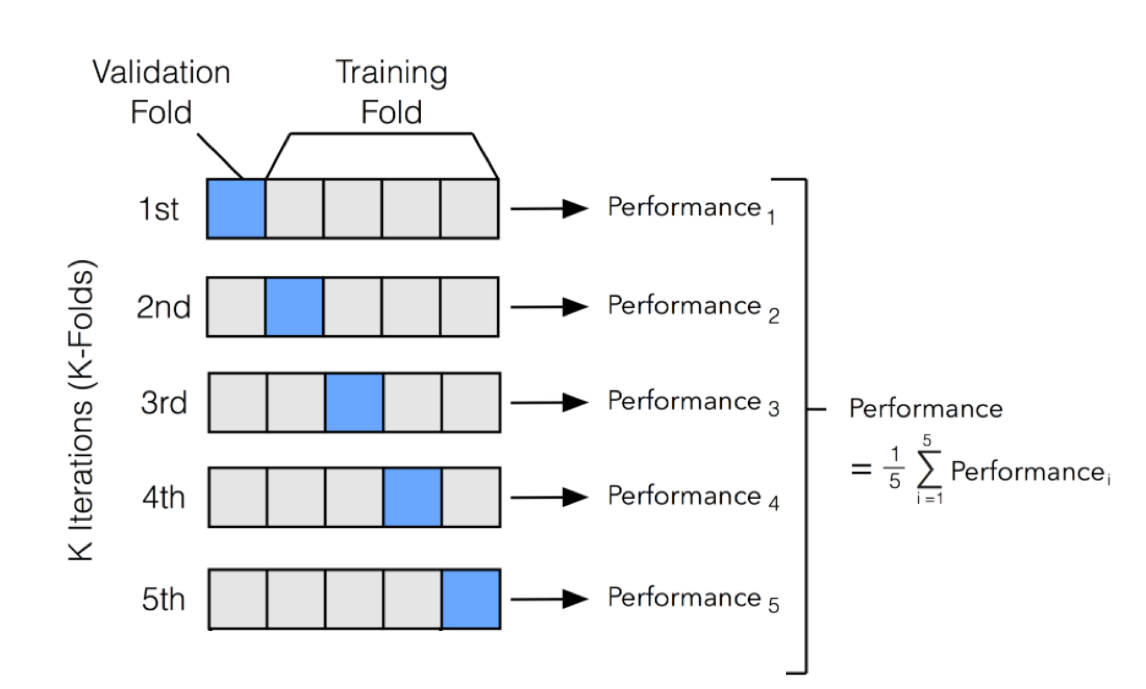

We use a learning algorithm with fixed hyperparameter settings to fit models to the training folds in each iteration. In 5-fold cross-validation, this procedure will result in 5 models fitted on distinct yet partly overlapping training sets and evaluated on non-overlapping validation sets. Eventually, we compute the cross-validation performance as the arithmetic mean over the $k$ performance estimates from the validation sets. The main benefit behind this approach versus a simple train/test split is to reduce the pessimistic bias by using more training data in contrast to setting aside a relatively large portion of the dataset as test data.

The following section shows a vanilla implementation of how to generate a K-fold data split.

In [2]:
class KFolds:
    """
    K-Folds cross-validation
    Provides train/test indices to split data in train/test sets. Split
    dataset into k consecutive folds; Each fold is then used once as 
    a validation while the k - 1 remaining folds form the training set

    Parameters
    ----------
    n_splits : int
        number of folds. Must be at least 2
    
    shuffle : bool, default True
        whether to shuffle the data before splitting into batches
    
    seed : int, default 4321
        When shuffle = True, pseudo-random number generator state used for
        shuffling; this ensures reproducibility
    """
    def __init__(self, n_splits, shuffle = True, seed = 4321):
        self.seed = seed
        self.shuffle = shuffle
        self.n_splits = n_splits
        
    def split(self, X):
        """pass in the data to create train/test split for k fold"""
        # shuffle modifies indices inplace
        n_samples = X.shape[0]
        indices = np.arange(n_samples)
        if self.shuffle:
            rstate = np.random.RandomState(self.seed)
            rstate.shuffle(indices)

        for test_mask in self._iter_test_masks(n_samples, indices):
            train_index = indices[np.logical_not(test_mask)]
            test_index = indices[test_mask]
            yield train_index, test_index
        
    def _iter_test_masks(self, n_samples, indices):
        """
        create the mask for the test set, then the indices that
        are not in the test set belongs in the training set
        """
        # indicate the number of samples in each fold, and also
        # make sure the ones that are not evenly splitted also
        # gets assigned to a fold (e.g. if we do 2 fold on a
        # dataset that has 5 samples, then 1 will be left out,
        # and has to be assigned to one of the other fold)
        fold_sizes = (n_samples // self.n_splits) * np.ones(self.n_splits, dtype = np.int)
        fold_sizes[:n_samples % self.n_splits] += 1

        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            test_indices = indices[start:stop]
            test_mask = np.zeros(n_samples, dtype = np.bool)
            test_mask[test_indices] = True
            yield test_mask
            current = stop

In [4]:
# create some sample data
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [5, 6]])
y = np.array([1, 2, 3, 4, 5])

kf = KFolds(n_splits = 2, shuffle = False, seed = 4312)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    

from sklearn.model_selection import KFold
print('\nconfirm results with scikit-learn')
kf = KFold(n_splits = 2, shuffle = False)
for train_index, test_index in kf.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

TRAIN: [3 4] TEST: [0 1 2]
TRAIN: [0 1 2] TEST: [3 4]

confirm results with scikit-learn
TRAIN: [3 4] TEST: [0 1 2]
TRAIN: [0 1 2] TEST: [3 4]


Here we implemented the simple version of K-fold, we should also keep in mind that some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling as implemented in [`StratifiedKFold`](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html#sklearn.model_selection.StratifiedKFold). Stratified basically means each set contains approximately the same percentage of samples of each target class as the complete set.

---

Now that have a sense of what K-fold cross validation is doing, let's look at how it can be used with hyperparameter tuning.

So the general process is:

- We split our dataset into two parts, a training and an independent test set; we tuck away the test set for the final model evaluation step at the end
- In the second step, we can now experiment with various hyperparameter settings; we could use Bayesian Optimization, Randomized Search, or plain old Grid Search (more on this later, think of it as different ways of generating hyperparameter combinations). For each hyperparameter configuration, we apply the K-fold cross validation on the training set, resulting in multiple models and performance estimates. See figure below:

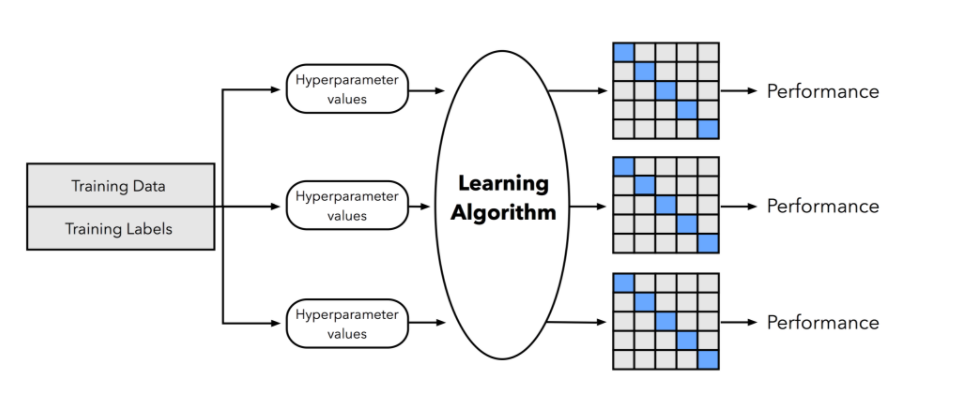


- After finding the best set of hyperparameter, we take the best-performing setting for that model and use the complete training set for model fitting.

- Then we make use of the independent test set we withheld at the beginning to evaluate the model that we obtained


# References

- [Github: scikit-learn's KFold](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/model_selection/_split.py#L347)
- [Github: scikit-learn's GridSearch](https://github.com/scikit-learn/scikit-learn/blob/14031f6/sklearn/model_selection/_search.py#L685)
- [Scikit-learn Documentation: Tuning the hyper-parameters of an estimator](http://scikit-learn.org/stable/modules/grid_search.html)
- [Scikit-learn Documentation: Cross-validation: evaluating estimator performance](http://scikit-learn.org/stable/modules/cross_validation.html)
- [Scikit-learn Documentation: Comparing randomized search and grid search for hyperparameter estimation](http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html#sphx-glr-auto-examples-model-selection-randomized-search-py)
- [Blog: Smarter Parameter Sweeps (or Why Grid Search Is Plain Stupid)](https://medium.com/rants-on-machine-learning/smarter-parameter-sweeps-or-why-grid-search-is-plain-stupid-c17d97a0e881)
- [Blog: Model evaluation, model selection, and algorithm selection in machine learning Part III - Cross-validation and hyperparameter tuning](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html)
- [Reference code](http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/model_selection/model_selection.ipynb)<br>                                                                                                          